<a href="https://colab.research.google.com/github/balrajparsi/balrajparsi/blob/AI_assigenments/Balraj_Parsi_Autoencoder_FashionMNIST_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👖 Autoencoders on Fashion MNIST

In this notebook, we'll walk through the steps required to train your own autoencoder on the fashion MNIST dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

# from notebooks.utils import display  # Removed to make notebook standalone

def display(images, titles=None, num_rows=1, figsize=(15, 3), cmap="gray"):
    """Display a list/array of images in a single row (or multiple rows).
    Works for Fashion-MNIST (28x28) and similar."""
    import numpy as np
    import matplotlib.pyplot as plt

    if images is None:
        print("No images to display.")
        return

    images = np.array(images)
    n = len(images)
    if n == 0:
        print("No images to display.")
        return

    num_cols = int(np.ceil(n / num_rows))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = np.array(axes).reshape(-1)

    for i in range(num_rows * num_cols):
        ax = axes[i]
        ax.axis("off")
        if i >= n:
            continue
        img = images[i]
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)
        ax.imshow(img, cmap=cmap)
        if titles is not None and i < len(titles):
            ax.set_title(str(titles[i]), fontsize=9)

    plt.tight_layout()
    plt.show()

## 0. Parameters <a name="parameters"></a>

In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 10

In [ ]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [ ]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

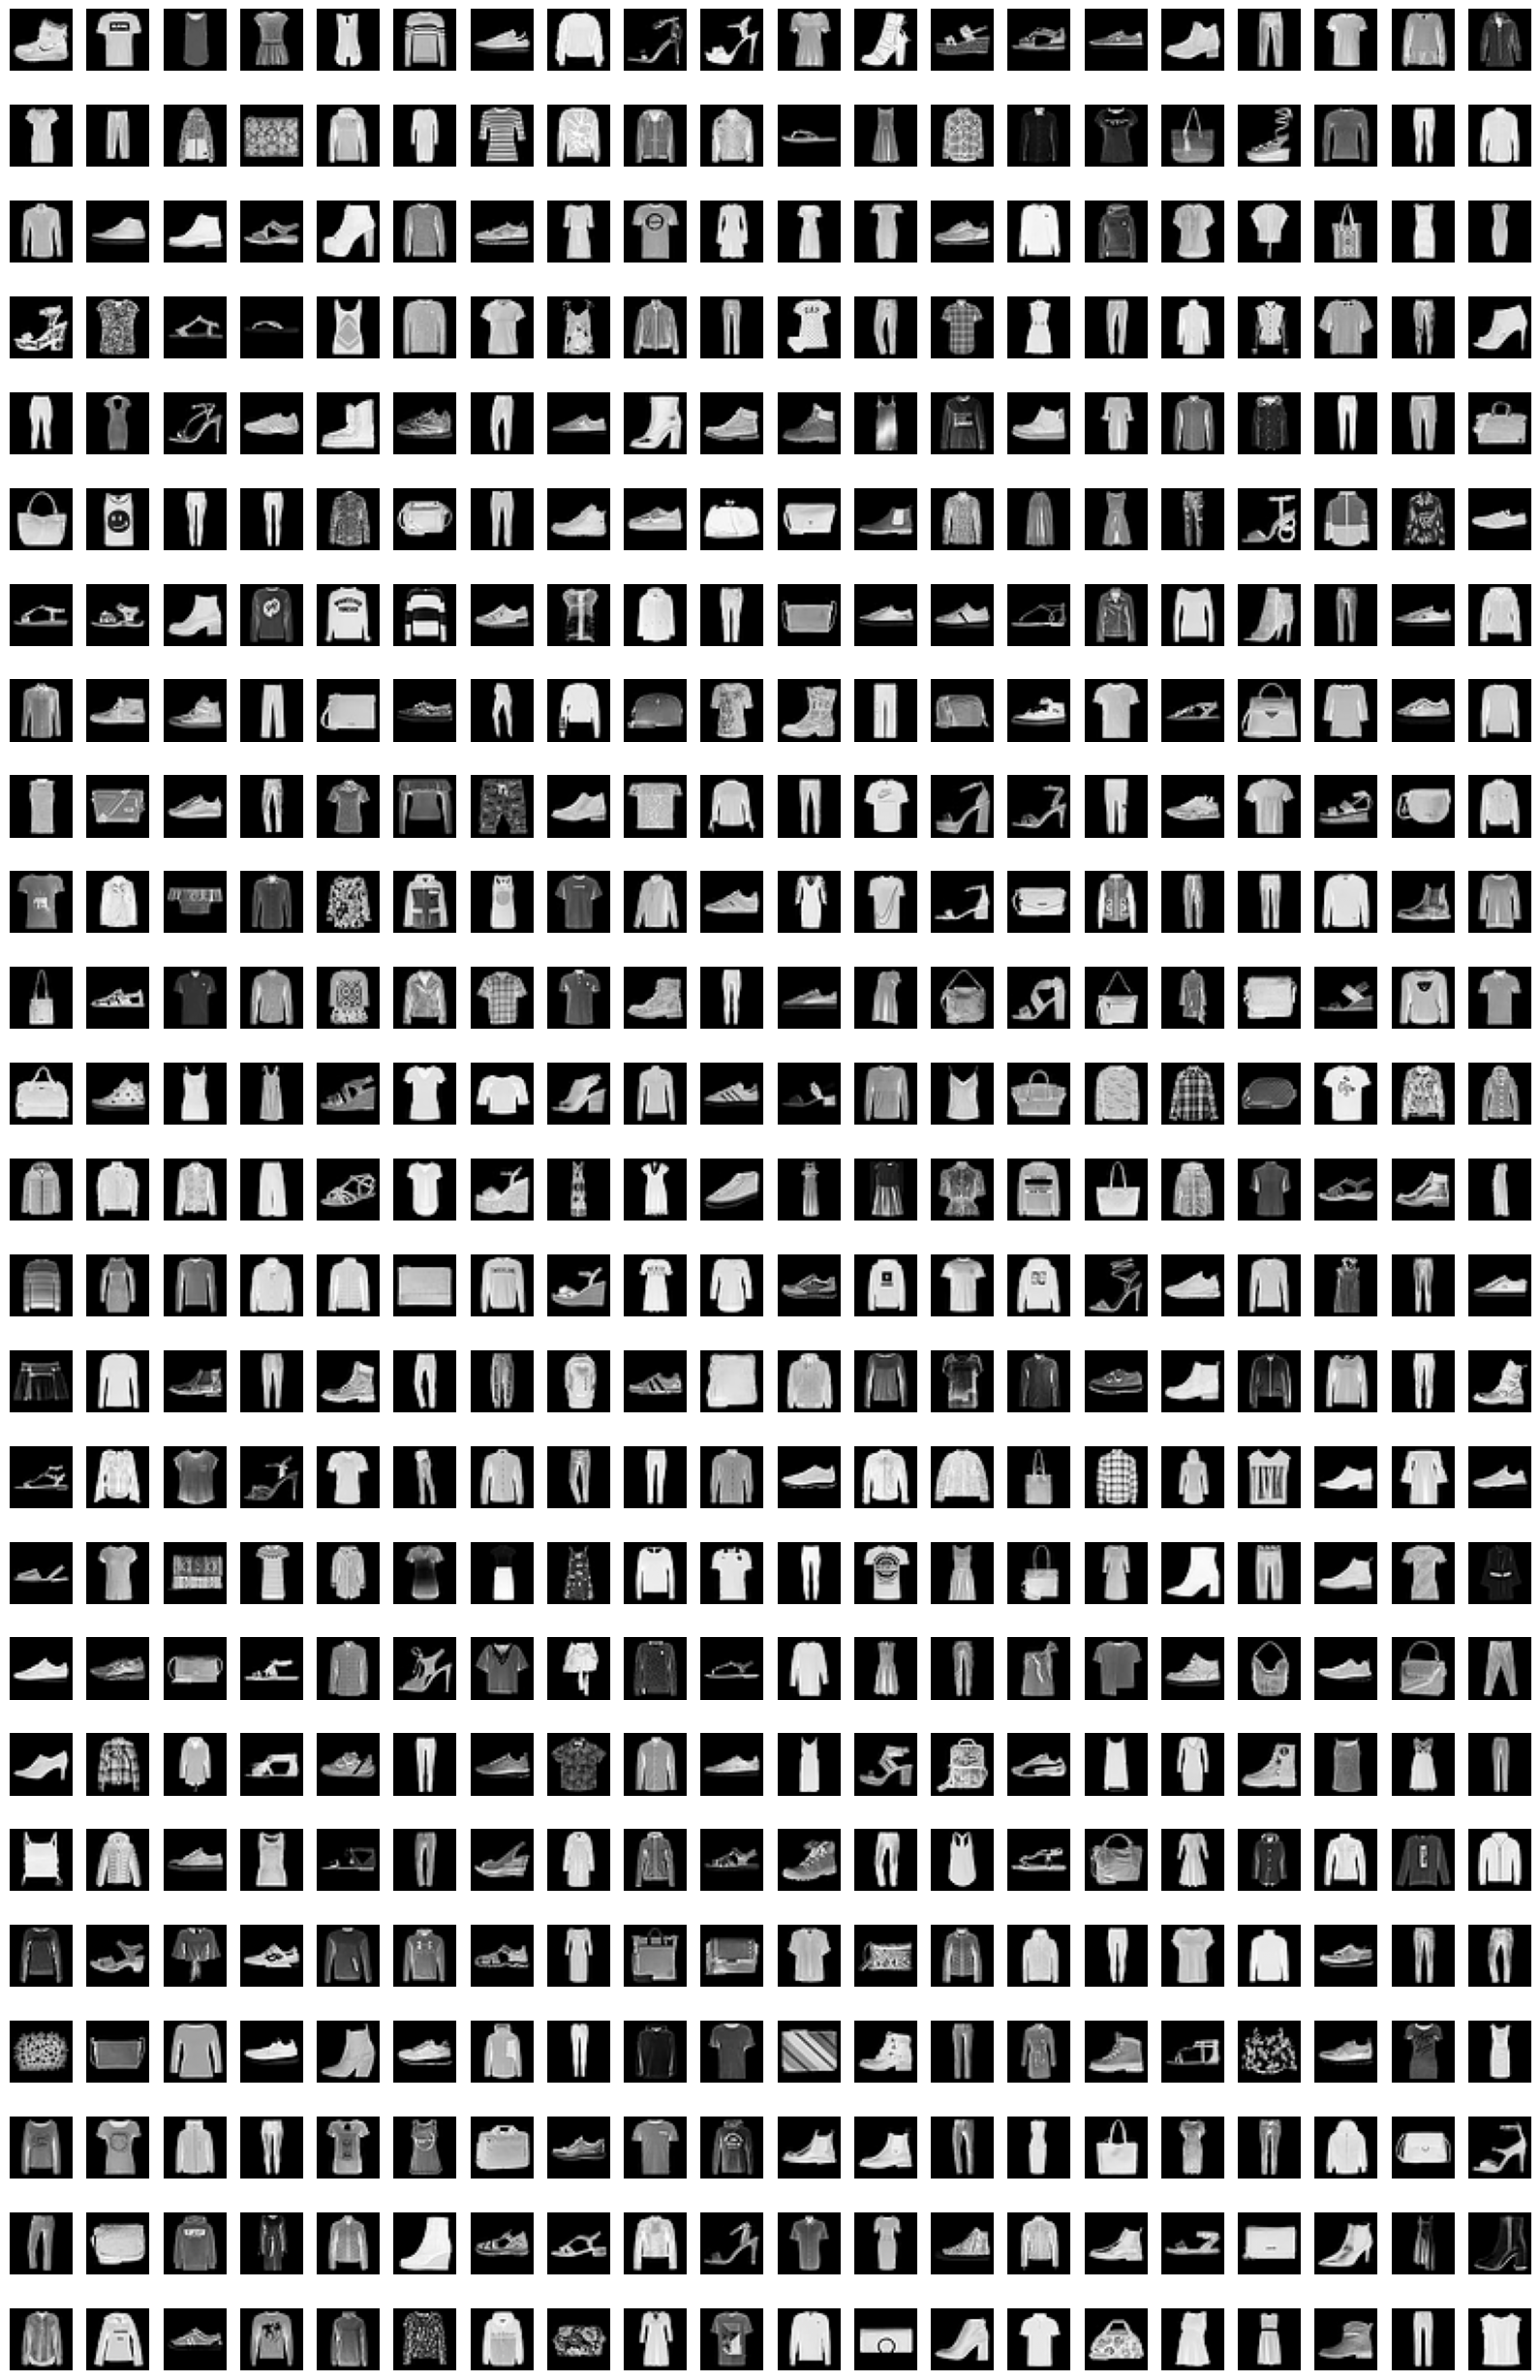

In [ ]:
# Show some items of clothing from the training set
images = x_train[:500]
cols = 20
rows = int(np.ceil(len(images) / cols))

plt.figure(figsize=(16, rows))
for i in range(len(images)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()


## 2. Build the autoencoder <a name="build"></a>

In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_10 (Functional)      │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the autoencoder <a name="train"></a>

In [ ]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [ ]:
from tensorflow.keras import callbacks

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/best_model.keras",  # must end with .keras or .h5
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=1,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [ ]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.3589
Epoch 1: loss improved from inf to 0.29554, saving model to ./checkpoint/best_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 50s 81ms/step - loss: 0.3588 - val_loss: 0.2625
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2591
Epoch 2: loss improved from 0.29554 to 0.25767, saving model to ./checkpoint/best_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - loss: 0.2591 - val_loss: 0.2562
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2540
Epoch 3: loss improved from 0.25767 to 0.25364, saving model to ./checkpoint/best_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - loss: 0.2540 - val_loss: 0.2541
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2523
Epoch 4: loss improved from 0.25364 to 0.25173, saving model to ./checkpoint/best_model.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - loss: 0.2523 - val_loss: 0.2521
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/

In [ ]:
import os
os.makedirs("./models", exist_ok=True)

autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")


## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [ ]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [ ]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Example real clothing items


/tmp/ipython-input-491369527.py:41: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


Reconstructions


I chose the five test images with the highest reconstruction MSE because this is a transparent,data-driven selection criterion that highlights the model’s hardest cases, making the discrepancy analysis more meaningful than random sampling.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Run reconstructions on the full test set
x_test_recon = autoencoder.predict(x_test, verbose=0)

# 2) Compute per-image reconstruction error (MSE over pixels)
# Fashion-MNIST is grayscale, values in [0,1]
per_img_mse = np.mean((x_test - x_test_recon) ** 2, axis=(1, 2, 3))

# 3) Pick 5 images with the highest error (your "own choice", data-driven)
top5_idx = np.argsort(per_img_mse)[-5:][::-1]
top5_idx


array([4505, 8943, 3999, 1537, 5993])

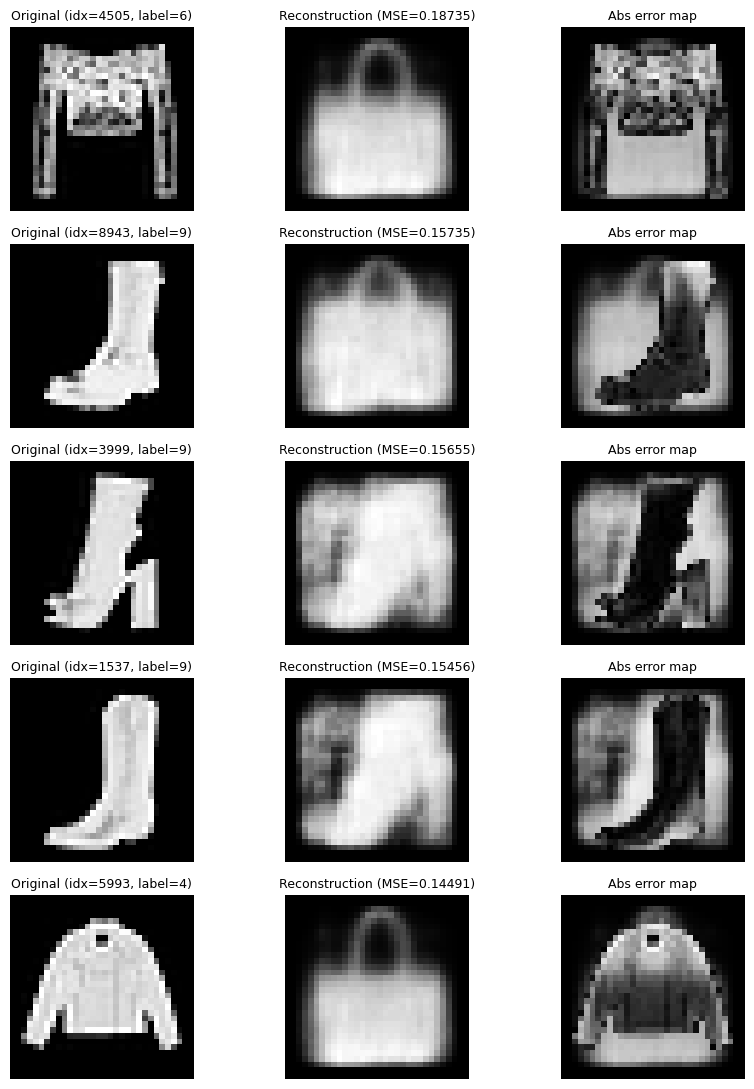

In [ ]:
# Helper to visualize originals vs reconstructions side-by-side
def show_original_vs_recon(indices, title_prefix=""):
    n = len(indices)
    fig, axes = plt.subplots(n, 3, figsize=(9, 2.2 * n))
    if n == 1:
        axes = np.array([axes])

    for row, idx in enumerate(indices):
        orig = x_test[idx]
        recon = x_test_recon[idx]
        err = np.abs(orig - recon)

        # Remove channel dim for display
        o = orig.squeeze(-1)
        r = recon.squeeze(-1)
        e = err.squeeze(-1)

        axes[row, 0].imshow(o, cmap="gray")
        axes[row, 0].set_title(f"{title_prefix}Original (idx={idx}, label={int(y_test[idx])})", fontsize=9)
        axes[row, 0].axis("off")

        axes[row, 1].imshow(r, cmap="gray")
        axes[row, 1].set_title(f"Reconstruction (MSE={per_img_mse[idx]:.5f})", fontsize=9)
        axes[row, 1].axis("off")

        # axes[row, 2].imshow(e, cmap="gray")
        axes[row, 2].imshow(e, cmap="gray", vmin=0.0, vmax=1.0)
        axes[row, 2].set_title("Abs error map", fontsize=9)
        axes[row, 2].axis("off")

    plt.tight_layout()
    plt.show()

show_original_vs_recon(top5_idx)


## 5. Embed using the encoder <a name="encode"></a>

In [ ]:
# Encode the example images
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Some examples of the embeddings
print(embeddings[:10])

[[ 0.8229862   0.8503469 ]
 [-2.071565   -3.362337  ]
 [ 7.4361377  -6.451379  ]
 [ 4.465285   -3.2369812 ]
 [-0.8055117  -1.3567269 ]
 [ 4.113598   -4.6198254 ]
 [ 0.17015587 -1.4827213 ]
 [-0.598096   -1.6903151 ]
 [ 3.8780918   0.56736475]
 [ 2.014046    0.39759922]]


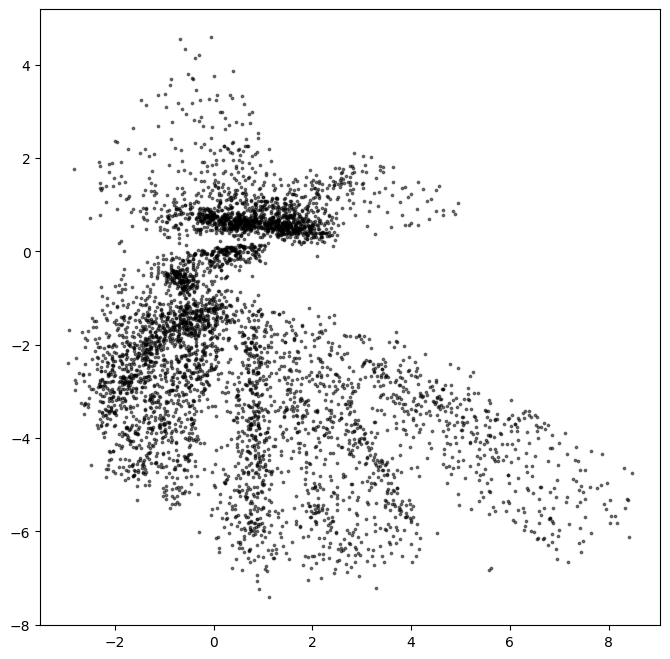

In [ ]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

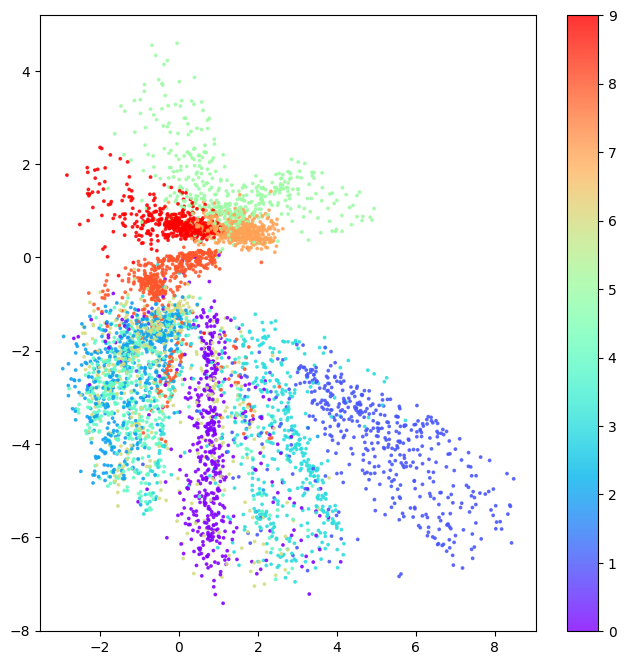

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## 6. Generate using the decoder <a name="decode"></a>

In [ ]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


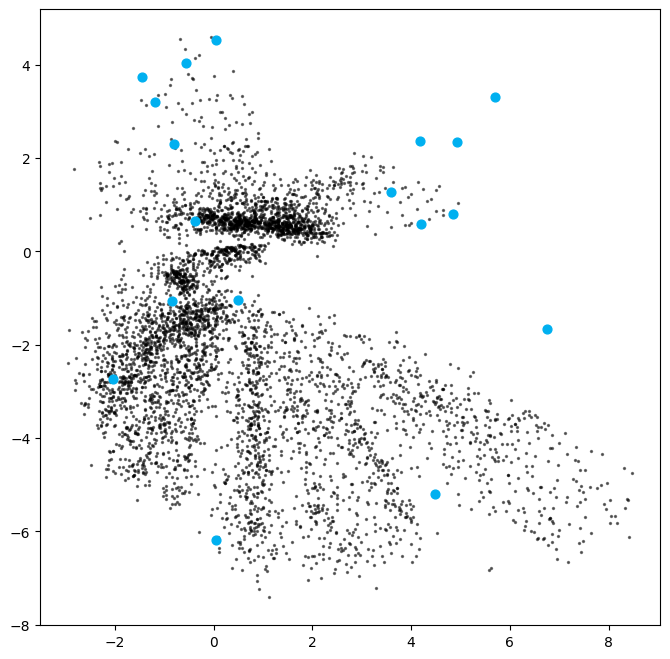

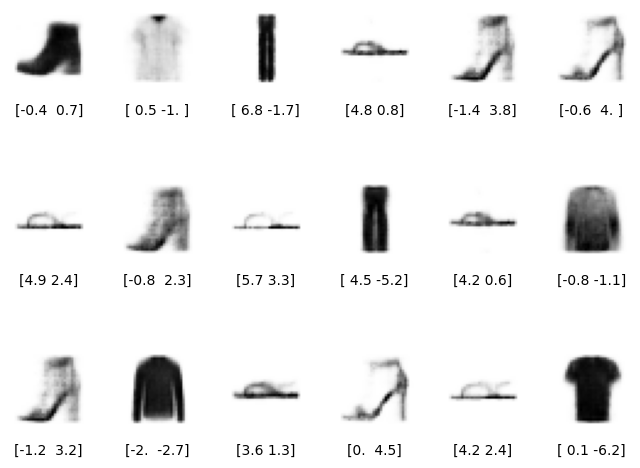

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


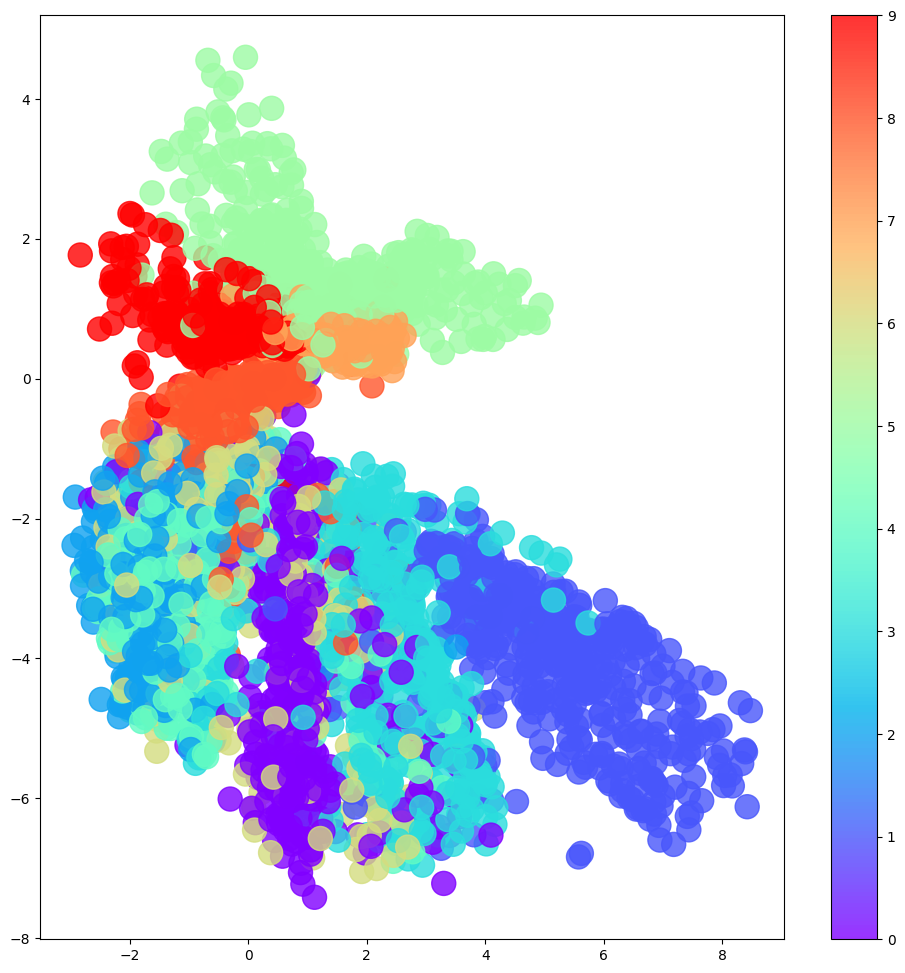

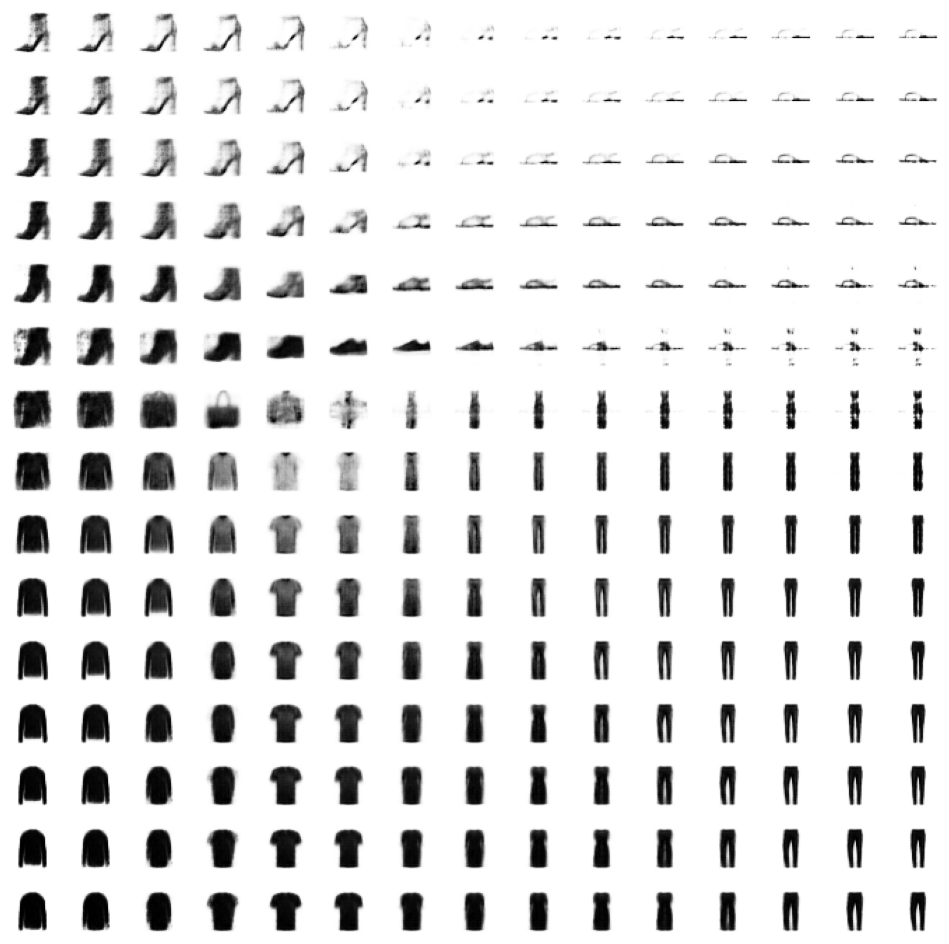

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")